In [20]:
%pip install qiskit
%pip install qiskit --upgrade
%pip install 'qiskit[nature]'
%pip install qiskit-aer
%pip install qiskit_algorithms
#%pip install --prefer-binary pyscf # this library can have some issues with pip in macos
%pip install matplotlib 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 6.9 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Quantum Simulation of the $H_2$ Molecule

### 1. Molecular Hamiltonian:

The Hamiltonian for the $H_2$ molecule comprises the kinetic energy of the electrons, the potential energies due to electron-nuclear interactions, and the electron-electron interactions:

$ \hat{H} = \sum_{i,j} t_{ij} a_i^\dagger a_j + \frac{1}{2} \sum_{i,j,k,l} V_{ijkl} a_i^\dagger a_j^\dagger a_k a_l $

Where:
- $ a_i^\dagger $ and $ a_i $ represent the fermionic creation and annihilation operators, respectively.
- $ t_{ij} $ and $ V_{ijkl} $ are the one-electron and two-electron integrals.

### 2. Mapping to Qubits:

For quantum computations, the fermionic Hamiltonian needs to be translated into a qubit Hamiltonian. The Jordan-Wigner transformation is commonly used, where each fermionic mode corresponds to a qubit:

$ a_j = \frac{1}{2} (X_j + i Y_j) \prod_{k=1}^{j-1} Z_k $

Applying this transformation, the molecular Hamiltonian is expressed as a sum of tensor products of Pauli matrices (X, Y, Z).


In [75]:
import qiskit as qk
from qiskit_nature import settings
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.quantum_info import Statevector
from qiskit.primitives import Estimator
from qiskit.algorithms.time_evolvers import TimeEvolutionProblem, TrotterQRTE
from qiskit.synthesis import SuzukiTrotter


import numpy as np
import matplotlib.pyplot as plt

settings.use_pauli_sum_op = False

## Quantum Simulation of $H_2$ Molecule using Qiskit

### 1. **Defining the Molecule**:
- Utilize Qiskit's `PySCFDriver` to define the $H_2$ molecule.
- Specify the atomic coordinates of the two hydrogen atoms and choose an appropriate basis set (e.g., `sto3g`).

### 2. **Hamiltonian Transformation**:
- The electronic structure of the $H_2$ molecule is initially described in terms of fermionic creation and annihilation operators.
- Transform this fermionic Hamiltonian into a qubit (spin) Hamiltonian suitable for quantum computation.
- Two common transformations are:
  - **Jordan-Wigner Transformation**: Provides a direct mapping of fermions to qubits.
    - $ a_j \rightarrow \frac{1}{2} (X_j + i Y_j) \prod_{k=1}^{j-1} Z_k $
    - $ a_j^\dagger \rightarrow \frac{1}{2} (X_j - i Y_j) \prod_{k=1}^{j-1} Z_k $
  - **Bravyi-Kitaev Transformation**: A more efficient mapping especially for systems with local interactions, but is more complex in form.

### 3. **Quantum Algorithms**:
- With the qubit Hamiltonian in hand, employ quantum algorithms like the Variational Quantum Eigensolver (VQE) to estimate the ground state energy of the $H_2$ molecule.


In [58]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735', basis='sto3g')# H2 molecule with bond length 0.735 angstrom
molecule = driver.run()

In [59]:
# We can choose mapper here
mapper  = JordanWignerMapper()
# mapper = BravyiKitaevMapper()

In [60]:
# Now we get the second quantized Hamiltonian
hamiltonian = molecule.hamiltonian.second_q_op()

# By obtaining this Hamiltonian in the second quantized form, we are then set up to transform it into a qubit representation
qubit_op = mapper.map(hamiltonian)


**Determine the HF Configuration:** 
   For a molecule like $H_2$, the HF ground state may be represented as $|1s_1 1s_0 \rangle$, where $1s_1$ and $1s_0$ indicate occupied 1s orbitals.

**Translate to Qubit Representation using Jordan-Wigner Transformation:** 
   Each molecular orbital has a spin-up and spin-down slot, equivalent to two qubits. An occupied slot is represented by a qubit in state $|1 \rangle$ and an unoccupied slot by $|0 \rangle$. For $H_2$, the state becomes $|1100 \rangle$.

**Convert to Statevector:** 
   The state $|1100 \rangle$ corresponds to the vector:
   $$
   |1100\rangle = \begin{bmatrix} 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   1 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 
   \end{bmatrix}
   $$

In [61]:
# Create the initial state
initial_state = Statevector.from_label("1100")

### 4. **Quantum Simulation**

Now, we will simulate the molecule to obtain its ground state using the **Variational Quantum Eigensolver (VQE)** method.

The **ansatz** prepares quantum states with parameters, $ \theta_k $, which are optimized by VQE:

$$ U(\theta) = e^{-i \theta_k H_k} $$

#### TwoLocal Ansatz

The `TwoLocal` ansatz in Qiskit is a quantum circuit template used for variational algorithms like VQE. It alternates between:
1. Single-qubit rotations: $RY$ gates.
2. Two-qubit entanglements: $CZ$ gates.

This structure provides a balance between expressiveness and computational efficiency, making it a popular choice for approximating quantum states.


In [62]:
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

### 4. **Optimization Algorithm**

**SPSA** is a popular optimizer used to minimize the expectation value of the energy:

$$ \min_{\theta} \langle \psi(\theta) | H | \psi(\theta) \rangle $$


In [63]:
# optimizer = SPSA(maxiter=20)
optimizer = COBYLA(maxiter=20)

## Ground state

Now that we've set up the problem, let's define the quantum backend and proceed with the actual simulation.


In [64]:
backend = qk.Aer.get_backend('statevector_simulator')

In [65]:
# Setting up the VQE Algorithm
aer_estimator = AerEstimator(run_options={"shots": 2048, "seed": 25})
qe_program = VQE(aer_estimator, ansatz, optimizer)

In [66]:
result = qe_program.compute_minimum_eigenvalue(operator=qubit_op)

In [67]:
print(f"Ground state energy: {result.eigenvalue.real} Ha")

Ground state energy: -1.484936066882807 Ha


For the $H_2$ molecule at a bond length of approximately $0.735$ angstroms, the ground state energy is approximately $-1.174$ Hartree [source](https://irinsubria.uninsubria.it/bitstream/11383/1715315/1/JCP_H2_1sigma_g.pdf).



# Evolution of the $H_2$ Molecule

Now, we will use **trotterization** to see how the $H_2$ molecule evolves.


In [109]:
final_time = 1.6
num_timesteps = 20

initial_state=Statevector.from_label('1100')
evolution_problem = TimeEvolutionProblem(qubit_op, initial_state=initial_state, time=final_time, aux_operators=[qubit_op])

In [110]:
second_order_formula = SuzukiTrotter(order=2) # This is the second order Trotter formula


trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator(), product_formula=second_order_formula) # The estimator is used to compute the expectation values of the Hamiltonian
result = trotter.evolve(evolution_problem)
evo_circuit = result.evolved_state # This gives the circuit that evolves the initial state to the final state

observables = np.array(np.array(result.observables)[:, :, 0]) # get the expectation values of the Hamiltonian

Ploting the results

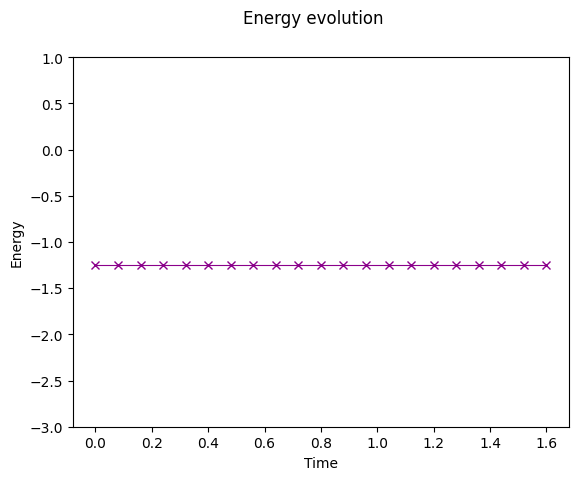

In [112]:
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state

fig, axes = plt.subplots(1, sharex=True)
axes.plot(times, observables[:, 0], marker='x', label='Second order', c='darkmagenta', ls='-', lw=.8)
axes.set_ylabel("Energy")
axes.set_xlabel("Time")
plt.ylim(-3 ,1)
fig.suptitle("Energy evolution")
plt.show()


Let's compare the values we got from Trotter evolution with the exact ones. We'll use the expression we talked about in the introduction.






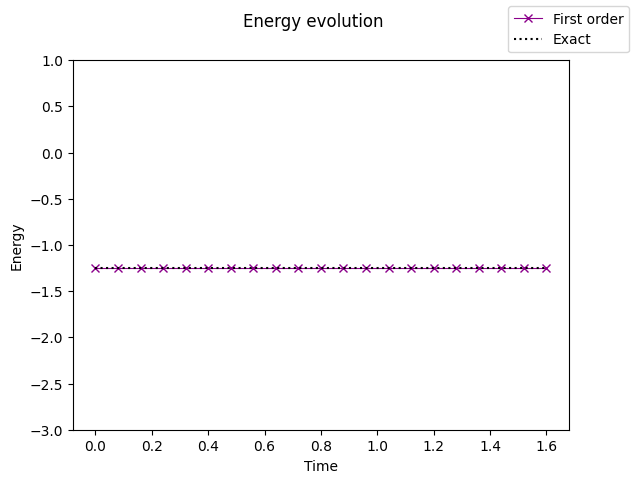

In [113]:
import scipy as sc

H_array = qubit_op.to_matrix()
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(qubit_op) for sv in exact_evolution])
axes.plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
fig.legend()
fig

## Perturbation

To introduce a new dynamic to our system, we will apply a perturbation. In the quantum domain, a perturbation can be represented by an additional term in the Hamiltonian that adds complexity to the system.

The perturbation function we're employing has the form:

$$
H_{\text{perturbation}} = -h \left( \sum_{i=0}^{N-1} \sin(\alpha) Z_i + \cos(\alpha) X_i \right)
$$

where:

- $N$ is the number of qubits in the system.
- $h$ is a scaling factor for the perturbation.
- $\alpha$ is an angle that controls the balance between the $Z$ and $X$ terms in the perturbation.
- $Z_i$ and $X_i$ are the Pauli-Z and Pauli-X matrices operating on the $i$-th qubit, respectively.



In [188]:
from qiskit.opflow import I, X, Y, Z
from qiskit.quantum_info import SparsePauliOp
from math import pi

In [253]:
def perturbation(N, h, alpha=0):
    Z_tuples = [('Z', [i], -h * np.sin(alpha)) for i in range(0, N)]
    X_tuples = [('X', [i], -h * np.cos(alpha)) for i in range(0, N)]

    hamiltonian = SparsePauliOp.from_sparse_list([*Z_tuples, *X_tuples], num_qubits=N)
    return hamiltonian.simplify()

In [171]:
pert_H = qubit_op + perturbation(4, 1, alpha=pi/8)

In [248]:
final_time = 10
num_timesteps = 60


#  Create the initial state and the evolution problem
initial_state=Statevector.from_label('1010')
evolution_problem = TimeEvolutionProblem(pert_H, initial_state=initial_state, time=final_time, aux_operators=[pert_H])

# Second and fourth order Trotter formula
second_order_formula = SuzukiTrotter(order=2) 
fourth_order_formula = SuzukiTrotter(order=4)


# Creates a Trotter algorithm and evolves the initial state
trotter1 = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())
trotter2 = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator(), product_formula=second_order_formula) 
trotter4 = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator(), product_formula=fourth_order_formula)

result1 = trotter1.evolve(evolution_problem)
result2 = trotter2.evolve(evolution_problem)
result4 = trotter4.evolve(evolution_problem)

evo_circuit1 = result1.evolved_state
evo_circuit2 = result2.evolved_state
evo_circuit4 = result4.evolved_state

observables1 = np.array(np.array(result1.observables)[:, :, 0])
observables2 = np.array(np.array(result2.observables)[:, :, 0])
observables4 = np.array(np.array(result4.observables)[:, :, 0])

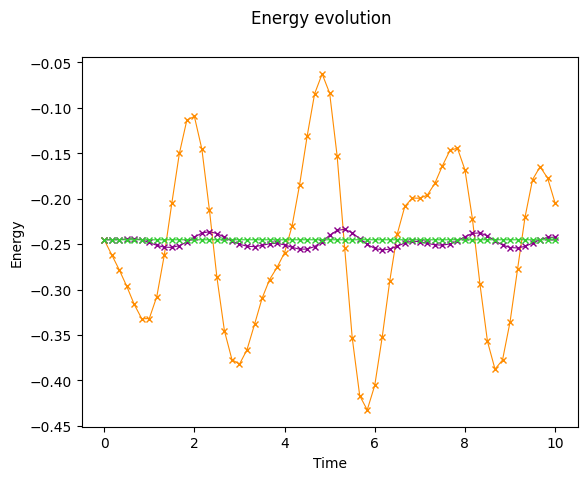

In [249]:
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state

fig, axes = plt.subplots(1, sharex=True)
axes.plot(times, observables1[:, 0], marker='x',markersize=4, label='First order', c='darkorange', ls='-', lw=.8)
axes.plot(times, observables2[:, 0], marker='x',markersize=4, label='Second order', c='darkmagenta', ls='-', lw=.8)
axes.plot(times, observables4[:, 0], marker='x',markersize=4, label='Fourth order', c='limegreen', ls='-', lw=.8)
axes.set_ylabel("Energy")
axes.set_xlabel("Time")
fig.suptitle("Energy evolution")
plt.show()

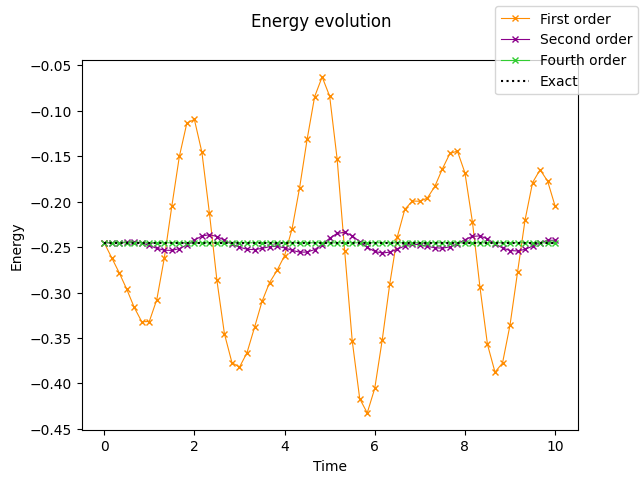

In [250]:
H_array = pert_H.to_matrix()
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(pert_H) for sv in exact_evolution])
axes.plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
fig.legend()
fig

## Investigating the Effect of Field Direction on $H_2$ Molecule Evolution

We're diving deep into the influence of the field direction on the time evolution of the H$_2$ molecule


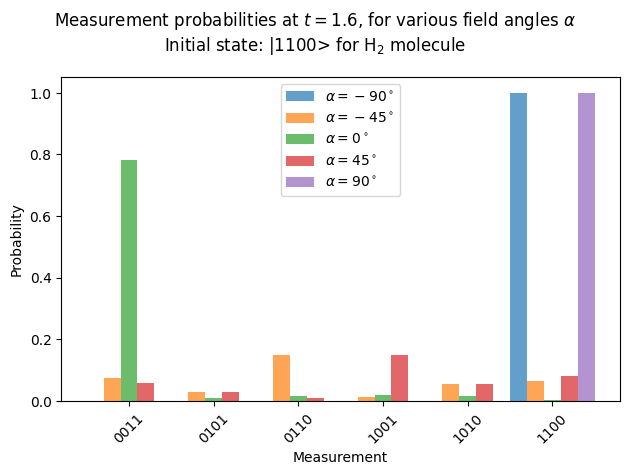

In [271]:
bar_width = .1

initial_state = Statevector.from_label("1100")
final_time = 1.6
eps = 1e-5

alphas = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, 5)
num_alphas = len(alphas)
num_states = 16
bar_positions = np.arange(num_states) * num_alphas * bar_width

# For storing all valid labels encountered over all iterations
all_valid_labels = set()

for i, alpha in enumerate(alphas):
    H_alpha = qubit_op + perturbation(4, 1, alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter2.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    
    # Filtering out the states with two electrons
    valid_keys = [key for key in amplitudes_dict.keys() if sum(map(int, key)) == 2]
    labels = valid_keys
    values = [amplitudes_dict[key] for key in valid_keys]
    
    all_valid_labels.update(labels)  # Add to our global list of valid labels
    
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / np.pi))}^\\circ$"
    plt.bar(bar_positions[:len(labels)] + i * bar_width, values, bar_width, label=alpha_str, alpha=.7)

# Adjust x-ticks to be centered under the groups of bars
plt.xticks(bar_positions[:len(all_valid_labels)] + (num_alphas - 1) * bar_width / 2, sorted(all_valid_labels), rotation=45)

plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: |1100> for H$_2$ molecule"
)
plt.legend()
plt.tight_layout()
plt.show()